In [8]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from util import resultsmngr, analyzer

In [9]:
unbalanced_results = resultsmngr.load('CensusIncome/results/1577576647.json')
balanced_results = resultsmngr.load('CensusIncome/results/1577579934.json')

def graphBestByModelType(results, **kw):
  best = analyzer.bestparams(results)
  fig, ax = plt.subplots()
  ax.set_ylim((0, 1))
  rex = ax.bar(range(len(best)), [best[b]['metrics']['testing-accuracy'] for b in best])
  ax.set_xticks(range(len(best)))
  ax.set_xticklabels(list(best))
  for r in rex:
    ht = r.get_height()
    ax.annotate(
      str(round(ht, 2)),
      xy=(r.get_x() + r.get_width() / 2, ht),
      xytext=(0, 3),  # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
  ax.set_title(kw.get('title', 'Accuracies'))
  return best

## Look at best performance for each model type

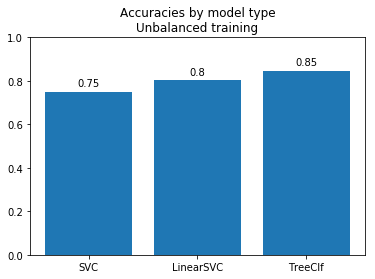

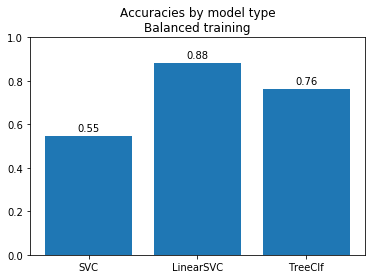

In [10]:
unb_best = graphBestByModelType(unbalanced_results, title="Accuracies by model type\nUnbalanced training")
b_best = graphBestByModelType(balanced_results, title="Accuracies by model type\nBalanced training")

## It makes sense to do worse in a balanced setting, since we aren't being lazy and always guessing the predominant class. I'm going to stick with the model that performed best in the balanced setting since it is more general and "real world"

In [11]:
print(json.dumps(b_best['LinearSVC'], indent=4))

{
    "params": null,
    "metrics": {
        "training-accuracy": 0.6142781033564199,
        "testing-accuracy": 0.8806878306878307
    }
}


## Seems like a LinearSVC will be best so lets GridSearch on a wide range of params

In [13]:
from util import preprocessor, splitfuncs, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# setup model and params to test
model = LinearSVC()
parameters = {
  'loss': ['hinge', 'squared_hinge'],
  'C': np.linspace(0.1, 5, 5)
}

# get data and train/test splits
pre = preprocessor()
trx, try_ = pre.data
# this is optional but lets me CV on balanced sets
splits = []
for i in range(5):
  tri, i, tei, j = splitfuncs.splitBalanced(trx, try_)
  splits.append((tri.index, tei.index))

# get our best params and retrain a new model
clf = GridSearchCV(model, parameters, cv=splits)
gs = clf.fit(trx, try_)
model = LinearSVC(**gs.best_params_)

# check model performance
trx, try_, tex, tey = splitfuncs.splitBalanced(trx, try_)
model.fit(trx, try_)
preds = model.predict(tex)
acc = metrics.acc(preds, tey)

print("Best params: ", gs.best_params_)
print("Accuracy:    ", acc)

Best params:  {'C': 0.1, 'loss': 'squared_hinge'}
Accuracy:     0.9004761904761904


## So that didn't get us very far, but good to know we're doing the best we can